# Krista, working on linking CO and KO
27 August 2015; 30 September 2015

This branch is starting with the common reactions for each Kmeans group.

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [351]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal
from itertools import chain
from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 

%matplotlib inline

Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

In [352]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [353]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [354]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [355]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [356]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [357]:
#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value, also uses CO_fromMATLAB as input 

In [358]:
#wonder whether these should be defined at the top?
import os.path
import cPickle as cpk

This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv file is a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [359]:
if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

#WorkingFile = cpk.load(open('exportMetabolites.csv.pickle','r'))


In [360]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [361]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [362]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [363]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of things came in handy, so define it up front. Actually want something that can't change 
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
#days = ('S1','S2','S3','S4','S5') #this makes a tuple (immutable)
CO_RawData_pruned = m.loc[:,dayList]
del m

This is the new version, with the extended metadata. Parse the file into data and metadata.

In [364]:
#read in the KO data
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]

Consider various data normalization options here. For now, normalize to mean and move one.

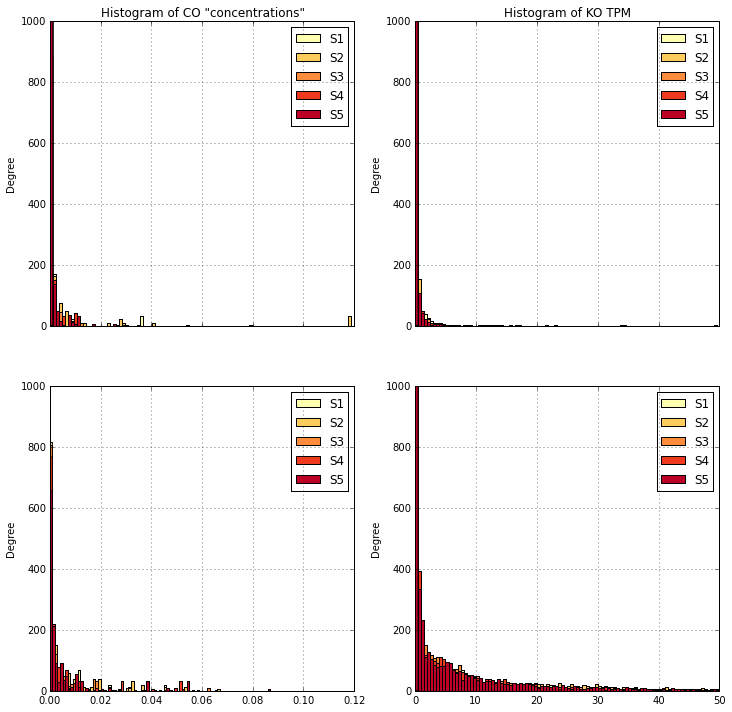

In [365]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData_pruned.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData_pruned.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

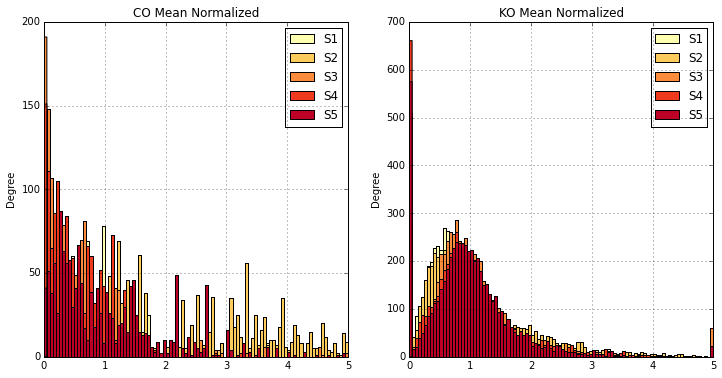

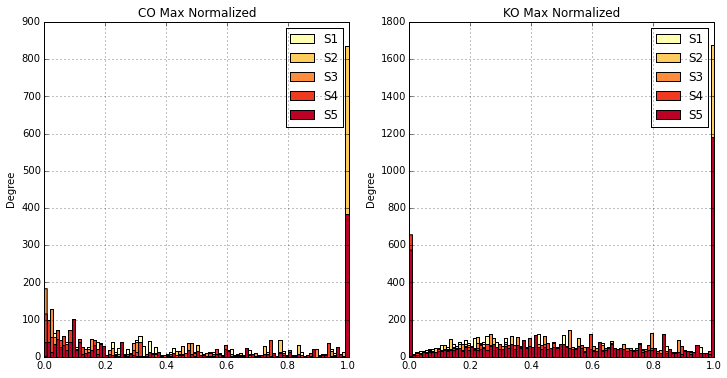

In [366]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData_pruned) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData_pruned)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

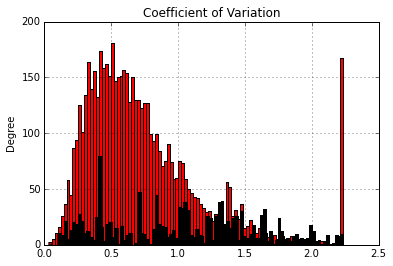

In [367]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData_pruned)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')

In [368]:
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
CO_limited_Norm2Mean = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

In [369]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):
    ssa = [] #can I put the silhoette average here?
    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
       
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        plt.show()
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)


Module created for script run in IPython


So...how do we actually decide how many clusters are best? Using silhouette analysis, looking for high silhouette_scores. For now I have set this to only look at a few options. However, there are also good silhouette scores with 2-5 clusters as well.

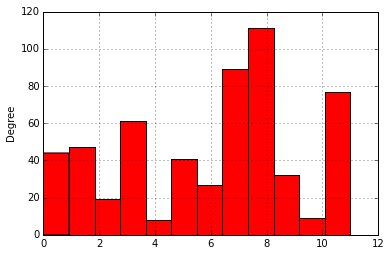

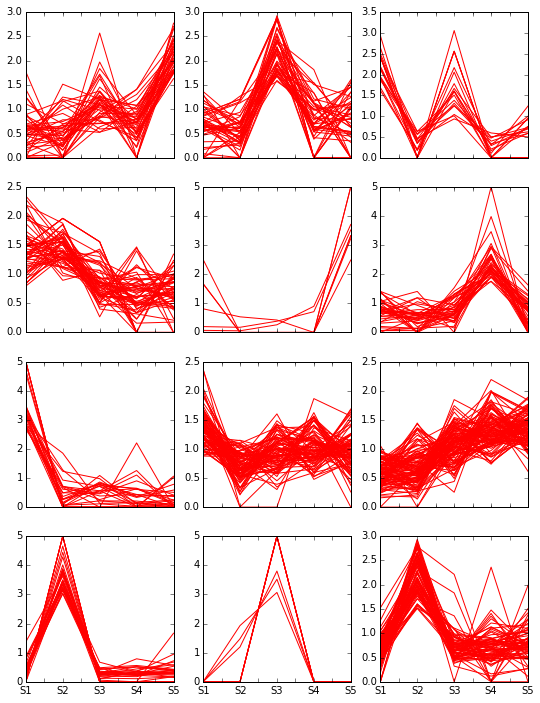

In [370]:
#run the Kmeans clustering on the KO data along first and plot results
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_limited_Norm2Mean, 12)
PlotKmeans(koClust,12,4,3, 'r') 

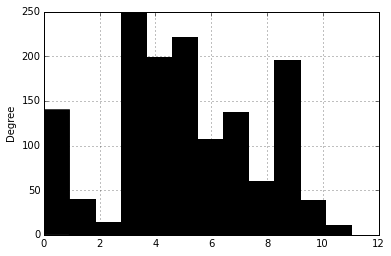

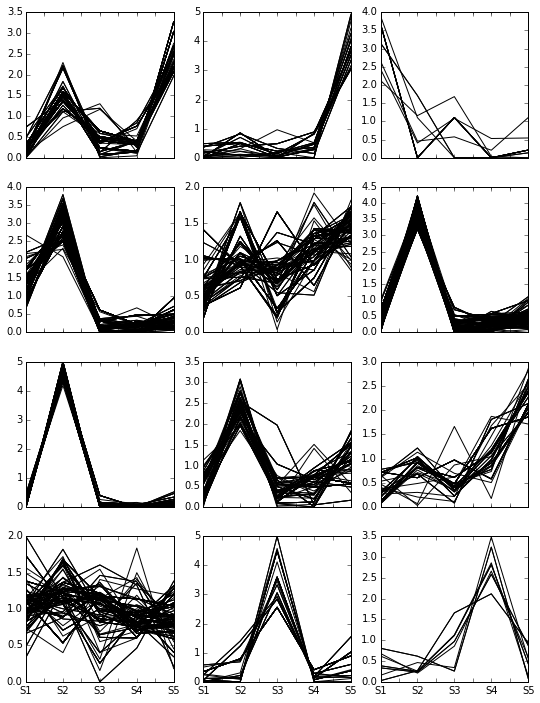

In [371]:
#plot up the results of one number of clusters for the CO data only
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_limited_Norm2Mean.loc[:,(dayList)], 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis (bc need to set # clusters) and are using the silhouette analysis to do that.

#Do Kmeans on combined CO and KO data

In [372]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean.loc[:,(dayList)])

('For n_clusters =', 3, 'The average silhouette_score is :', 0.39652267056936169)


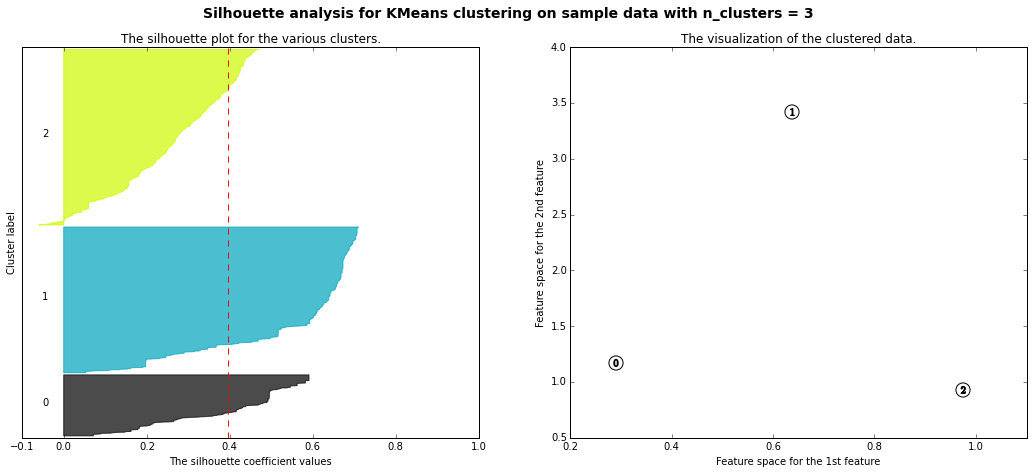

('For n_clusters =', 4, 'The average silhouette_score is :', 0.31952909042980893)


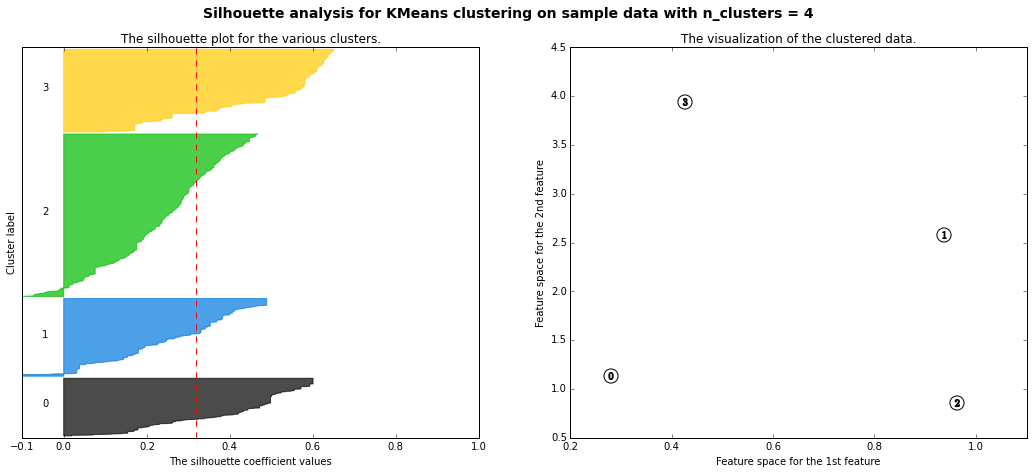

('For n_clusters =', 5, 'The average silhouette_score is :', 0.35074568189569649)


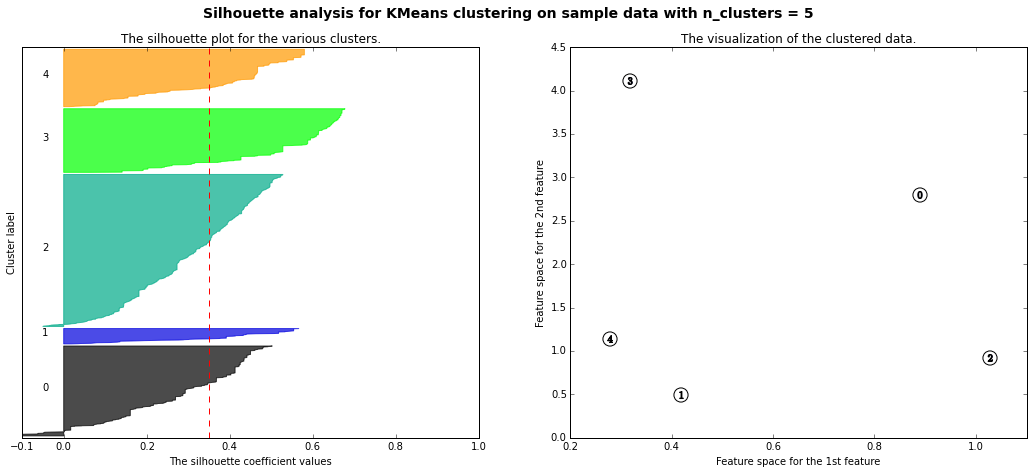

('For n_clusters =', 6, 'The average silhouette_score is :', 0.37266800215487433)


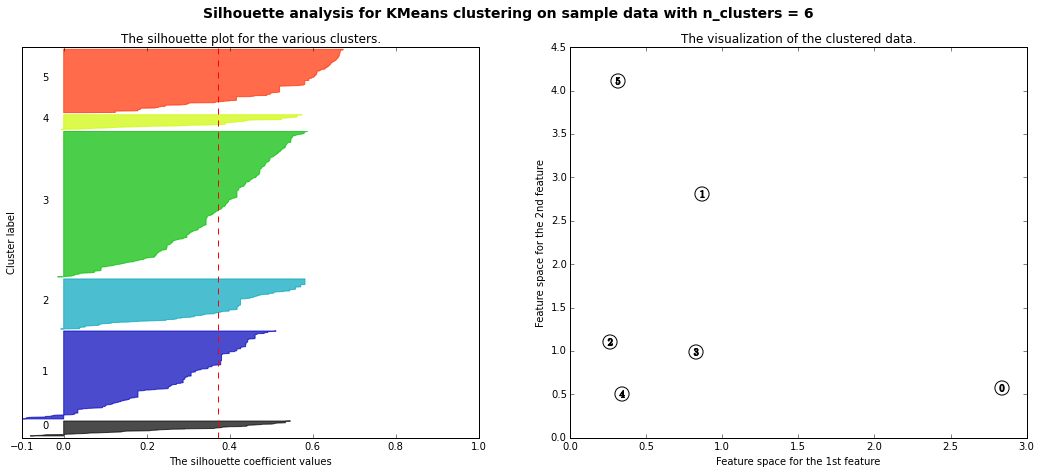

('For n_clusters =', 7, 'The average silhouette_score is :', 0.34401361093717558)


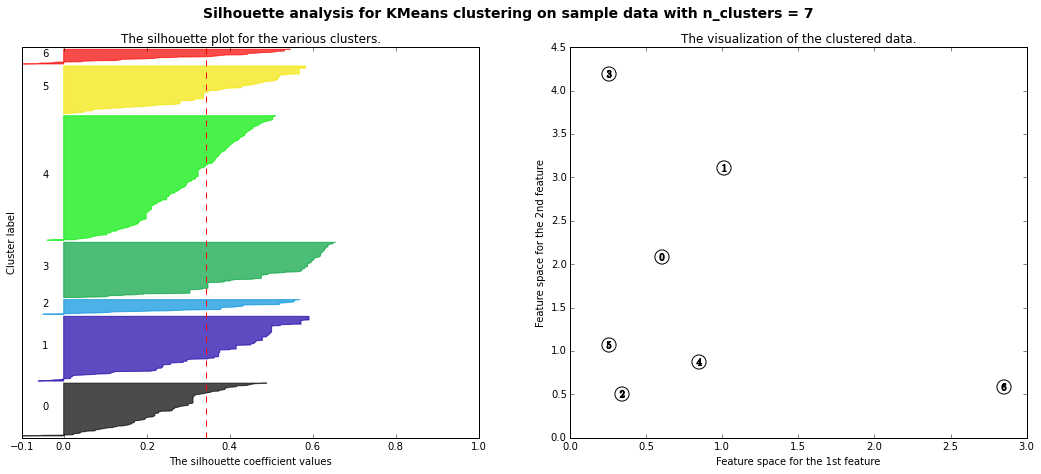

('For n_clusters =', 8, 'The average silhouette_score is :', 0.32938811898640702)


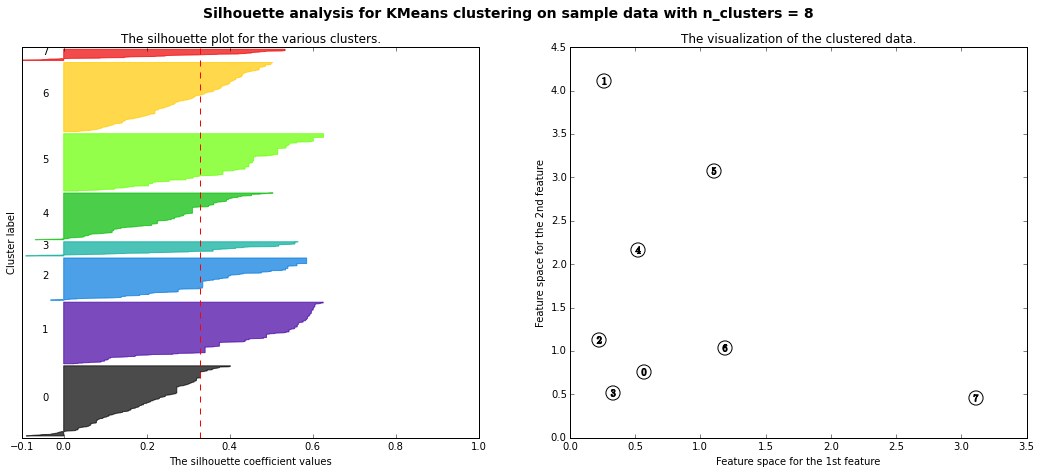

('For n_clusters =', 9, 'The average silhouette_score is :', 0.3334937648421048)


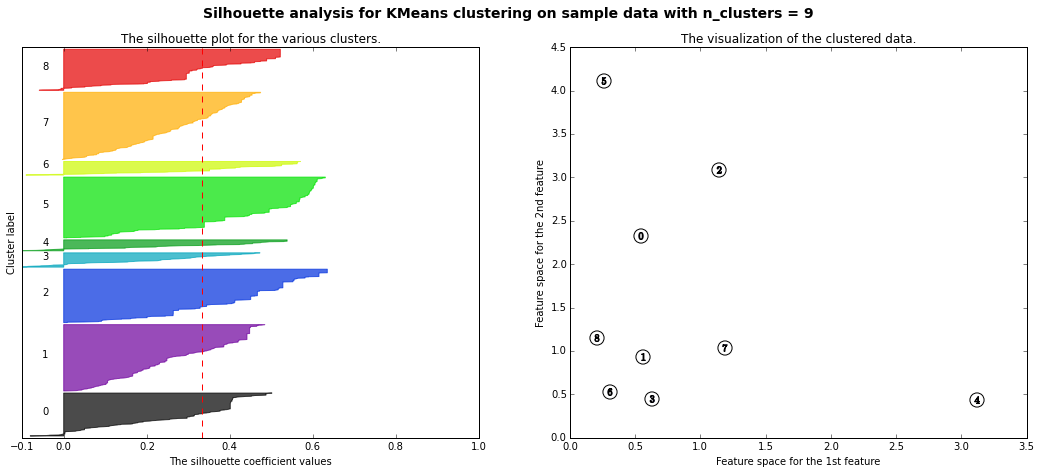

In [373]:
#Run silhoette analysis on a range of cluster options
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(3,10,1))

In [374]:
#completely lame...hand-copied the silhouette scores from one version of the silhouette figures
silAverage = [0.43, 0.37, 0.38, 0.40, 0.36, 0.32]

In [ ]:
plt.scatter(range(0,len(silAverage)), silAverage)
plt.grid() #put on a grid
plt.xlim(-1,20)

In [ ]:
#go back to Kmeans and finding the right group...found some mean to better quantify the 
#selection of the right number of clusters

In [ ]:
#(Combined_KO_CO_MeanNorm)

In [ ]:
#I have all the evaluation files from this 
#web site:http://www.turingfinance.com/clustering-countries-real-gdp-growth-part2/
#but I can't figure out how to just read in the *.py files and use the functions. Sticking them in here seems 
#super inefficient, but works.

In [375]:
import csv

class Data():
    """
    A class for downloading data from a CSV file
    :param file_name: the file name
    :return: the data
    """

    def __init__(self, file_name):
        self.file_name = file_name
        return

    def load_data(self):
        """
        This method opens the file and reads it in
        :return:
        """
        loaded_patterns = []
        file = open(self.file_name)
        row_number = 0
        labels = []
        for row in csv.reader(file):
            if row_number != 0:
                floats = []
                for j in range(len(row)):
                    if j != 0:
                        floats.append(float(row[j]))
                    else:
                        labels.append(row[j])
                loaded_patterns.append(floats)
            row_number += 1
        return np.array(loaded_patterns), labels


In [484]:
#this was the sample data, 19 dimensions
if False:
    data = Data("Final-Data-Set.csv")
    #pattern_labels are the rows...for us this will the RInumber
    pattern_labels = []
    patterns_data, pattern_labels = data.load_data()

In [541]:
#cheat for the moment...save the data for the Kmeans as a CSV file and then read it in.
#figure out the format later.
dataFilename = 'NB_combined_for_kmeans.csv'
Combined_KO_CO_MeanNorm.to_csv(dataFilename)

data = Data(dataFilename)
#pattern_labels are the rows...for us this will the RInumber
pattern_labels = []
patterns_data, pattern_labels = data.load_data()

In [543]:
import math
import random
import csv
import numpy as np
import cProfile
import hashlib

In [544]:
class VectorOperations():
    """
    This class contains useful implementations of methods which can be performed on vectors
    """

    @staticmethod
    def product(p_vec, q_vec):
        """
        This method returns the product of two lists / vectors
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the product of p_vec and q_vec
        """
        return p_vec * q_vec

    @staticmethod
    def square(p_vec):
        """
        This method returns the square of a vector
        :param p_vec: the vector to be squared
        :return: the squared value of the vector
        """
        return p_vec ** 2

    @staticmethod
    def norm(p_vec):
        """
        This method returns the norm value of a vector
        :param p_vec: the vector to be normed
        :return: the norm value of the vector
        """
        return np.sqrt(p_vec)


In [545]:
class Similarity:
    """
    This class contains instances of similarity / distance metrics. These are used in centroid based clustering
    algorithms to identify similar patterns and put them into the same homogeneous sub sets
    :param minimum: the minimum distance between two patterns (so you don't divide by 0)
    """

    def __init__(self, minimum):
        self.e = minimum
        self.vector_operators = VectorOperations()

    def manhattan_distance(self, p_vec, q_vec):
        """
        This method implements the manhattan distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the manhattan distance between vector one and two
        """
        return max(np.sum(np.fabs(p_vec - q_vec)), self.e)

    def square_euclidean_distance(self, p_vec, q_vec):
        """
        This method implements the squared euclidean distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the squared euclidean distance between vector one and two
        """
        diff = p_vec - q_vec
        return max(np.sum(diff ** 2), self.e)

    def euclidean_distance(self, p_vec, q_vec):
        """
        This method implements the euclidean distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the euclidean distance between vector one and two
        """
        return max(math.sqrt(self.square_euclidean_distance(p_vec, q_vec)), self.e)

    def half_square_euclidean_distance(self, p_vec, q_vec):
        """
        This method implements the half squared euclidean distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the half squared euclidean distance between vector one and two
        """
        return max(0.5 * self.square_euclidean_distance(p_vec, q_vec), self.e)

    def cosine_similarity(self, p_vec, q_vec):
        """
        This method implements the cosine similarity metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the cosine similarity between vector one and two
        """
        pq = self.vector_operators.product(p_vec, q_vec)
        p_norm = self.vector_operators.norm(p_vec)
        q_norm = self.vector_operators.norm(q_vec)
        return max(pq / (p_norm * q_norm), self.e)

    def tanimoto_coefficient(self, p_vec, q_vec):
        """
        This method implements the cosine tanimoto coefficient metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the tanimoto coefficient between vector one and two
        """
        pq = self.vector_operators.product(p_vec, q_vec)
        p_square = self.vector_operators.square(p_vec)
        q_square = self.vector_operators.square(q_vec)
        return max(pq / (p_square + q_square - pq), self.e)

    def fractional_distance(self, p_vec, q_vec, fraction=2.0):
        """
        This method implements the fractional distance metric. I have implemented memoization for this method to reduce
        the number of function calls required. The net effect is that the algorithm runs 400% faster. A similar approach
        can be used with any of the above distance metrics as well.
        :param p_vec: vector one
        :param q_vec: vector two
        :param fraction: the fractional distance value (power)
        :return: the fractional distance between vector one and two
        """
        # memoization is used to reduce unnecessary calculations ... makes a BIG difference
        memoize = True
        if memoize:
            key = self.get_key(p_vec, q_vec)
            x = memoization.get(key)
            if x is None:
                diff = p_vec - q_vec
                diff_fraction = diff ** fraction
                return max(math.pow(np.sum(diff_fraction), 1 / fraction), self.e)
            else:
                return x
        else:
            diff = p_vec - q_vec
            diff_fraction = diff ** fraction
            return max(math.pow(np.sum(diff_fraction), 1 / fraction), self.e)

    @staticmethod
    def get_key(p_vec, q_vec):
        """
        This method returns a unique hash value for two vectors. The hash value is equal to the concatenated string of
        the hash value for vector one and vector two. E.g. is hash(p_vec) = 1234 and hash(q_vec) = 5678 then get_key(
        p_vec, q_vec) = 12345678. Memoization improved the speed of this algorithm 400%.
        :param p_vec: vector one
        :param q_vec: vector two
        :return: a unique hash
        """
        # return str(hash(tuple(p_vec))) + str(hash(tuple(q_vec)))
        return str(hashlib.sha1(p_vec)) + str(hashlib.sha1(q_vec))

In [546]:
class Clustering:
    """
    An instance of the Clustering is a solution i.e. a particular partitioning of the (heterogeneous) data set into
    homogeneous subsets. For Centroid based clustering algorithms this involves looking at each pattern and assigning
    it to it's nearest centroid. This is done by calculating the distance between each pattern and every centroid and
    selecting the one with the smallest distance. Here we use are using fractional distance with the default parameters.

    :param d: dimensionality of the input patterns
    :param k: the pre-specified number of clusters & centroids
    :param z: the patterns in the data set
    :param min: the minimum distance (required to prevent division by zero)
    """

    def __init__(self, d, k, z, min):
        # print("Initializing solution ...")
        """
        Initializes a Clustering object with the specified parameters
        :param d: dimensionality of the input patterns
        :param k: the pre-specified number of clusters & centroids
        :param z: the patterns in the data set
        :param min: the minimum distance (required to prevent division by zero)
        """
        self.dimensionality = d
        self.num_clusters = k
        self.patterns = z
        self.solution = []
        for i in range(len(z)):
            self.solution.append(0)
        self.centroids = np.random.rand(k, d)
        self.e = min

    def re_init(self):
        """
        A method for reinitializing the solution
        """
        self.centroids = None
        self.centroids = np.random.rand(self.num_clusters, self.dimensionality)

    def assign_patterns(self):
        """
        This method iterates over all patterns and calculates the distances between that pattern and every centroid.
        These value are stored in [distances]. The assign_pattern method is then used to find the centroid with the
        smallest distance and update the 'label' i.e. centroid which the pattern is associated.
        """
        s = Similarity(self.e)
        # for each pattern
        for i in range(len(self.patterns)):
            # for each centroid
            distances = []
            for j in range(self.num_clusters):
                # calculate the distances
                distances.append(s.fractional_distance(self.centroids[j], self.patterns[i]))               
            # assign the pattern to a cluster
            self.assign_pattern(distances, i)

    def assign_pattern(self, distances, index):
        """
        This method updates the label i.e. centroid index \in (0, k-1) to which pattern z(index) belongs
        :param distances: distances to each centroid
        :param index: the index of the pattern we are assigning in z
        """
        self.solution[index] = 0
        smallest = distances[self.solution[index]]
        for i in range(len(distances)):
            if distances[i] < smallest:
                smallest = distances[i]
                self.solution[index] = i

    def update_centroids(self, s=1.0):
        """
        This method implements the mean-shift heuristic used by the K-means clustering algorithm. This heuristic
        updates the value of each centroid with the average value at each dimension of the patterns assigned to it.
        :param s: this is the scaling factor i.e. how much we want to diminish the movement of the centroids by
        """
        # Step 1 - initialize a variable to store the sum at each dimension of the patterns assigned to each centroid
        centroids_sum = []
        for i in range(self.num_clusters):
            centroids_sum.append([])
            for j in range(self.dimensionality):
                centroids_sum[i].append(0.0)
        # Step 2 - initialize a variable to store the count of patterns assigned to each centroid
        centroids_count = []
        for i in range(self.num_clusters):
            centroids_count.append(0.0)
        # Step 3 - Update the value of centroids_sum and centroids_count for step 4
        for i in range(len(self.solution)):
            for j in range(self.dimensionality):
                centroids_sum[self.solution[i]][j] += self.patterns[i][j]
            centroids_count[self.solution[i]] += 1
        # Step 4 - compute the averages (total / count) for each dimension for each centroid
        centroids_average = []
        for i in range(self.num_clusters):
            centroids_average.append([])
            for j in range(self.dimensionality):
                if centroids_count[i] > 0:
                    centroids_average[i].append(centroids_sum[i][j] / max(1.0, centroids_count[i]))
                else:
                    centroids_average[i].append(random.random())
        # Step 5 - set  each dimension of each centroid to the average of it's clusters values at that dimension
        for i in range(self.num_clusters):
            if s == 1.0:
                self.centroids[i] = None
                self.centroids[i] = centroids_average[i]
            else:
                for j in range(len(self.centroids[i])):
                    self.centroids[i][j] += (centroids_average[i][j] - self.centroids[i][j]) * s

    def k_means_clustering(self, n, s=1.0):
        """
        This method performs the K-means clustering algorithm on the data for n iterations. This involves updating the
        centroids using the mean-shift heuristic n-times and reassigning the patterns to their closest centroids.
        :param n: number of iterations to complete
        :param s: the scaling factor to use when updating the centroids
        pick on which has a better solution (according to some measure of cluster quality)
        """

        for i in range(n):
            self.assign_patterns()
            self.update_centroids(s)

    def print_solution(self, labels):
        """
        Prints out the clustering i.e. which patterns are assigned to which centroids. This can be cross-referenced
        with the label on each pattern to determine which countries are clustered together in space.
        :param labels: pattern labels
        """
        for i in range(len(self.solution)):
            print(labels[i], ",", self.solution[i])


In [552]:
# #do one Kmeans iteration (testing)
# num_clusters = 3 #set by the user
# clustering = Clustering(dimensions, num_clusters, patterns_data, 0.0001)
# memoization = {}
# clustering.k_means_clustering(7)

In [549]:
class ClusteringQuality:
    """
    Instances of this class implement the two measures of clustering quality discussed in the article, namely the davies
    bouldin index and the silhouette index. It also implements a number of useful helper methods.
    :param solution: the clustering solution of type Clustering
    :param minimum: the minimum distance allowable
    """

    def __init__(self, solution, minimum):
        """
        Initializes a ClusteringQuality object with a given Clustering solution and a minimum distance
        :param solution: this is an object of type Clustering
        :param minimum: this is the minimum distance allowed between two points
        """
        assert isinstance(solution, Clustering)
        self.solution = solution
        self.e = minimum

    def cluster_totals(self):
        """
        This method calculates the total distance from every centroid to every pattern assigned to it. It also records
        the number of patterns in each cluster which are used to compute average distances in cluster_averages()
        :return: a two dimensional list of [total cluster distance, total patterns in cluster] for each centroid
        """
        s = Similarity(self.e)
        # create array (will be 2d) to store total internal cluster distances and cluster counts for each centroid
        cluster_distances_counts = []
        for i in range(self.solution.num_clusters):
            ith_cluster_count = 0.0
            ith_cluster_distance = 0.0
            for z in range(len(self.solution.solution)):
                # update the count and the total distance for the centroid z[i] belongs to (whichever one that is)
                if self.solution.solution[z] == i:
                    ith_cluster_count += 1
                    ith_cluster_distance += s.fractional_distance(self.solution.patterns[z], self.solution.centroids[i])
            # add the result to the 2d list
            cluster_distances_counts.append([ith_cluster_distance, max(ith_cluster_count, 1.0)])
        return np.array(cluster_distances_counts)

    def cluster_averages(self):
        """
        Receives output from cluster_totals() and computes the average distance per centroid
        :return: average distance from each centroid to the patterns assigned to it
        """
        # create list to store averages in
        cluster_averages = []
        # get the total internal cluster distances plus the counts for each centroid / cluster
        cluster_distances_counts = self.cluster_totals()
        for i in range(len(cluster_distances_counts)):
            # calculate the averages and add it to the list
            cluster_averages.append(cluster_distances_counts[i][0] / cluster_distances_counts[i][1])
        return np.array(cluster_averages)

    def davies_bouldin(self):
        """
        This method computes the davies-bouldin (db) of a given clustering.
        :return: the davies bouldin value of the clustering
        """
        # get the average internal cluster distances
        cluster_averages = self.cluster_averages()
        # create variable for db
        davies_bouldin = 0.0
        s = Similarity(self.e)
        # for each cluster / centroid i
        for i in range(self.solution.num_clusters):
            # for each cluster / centroid j
            for j in range(self.solution.num_clusters):
                # when i and j are not the same cluster / centroid
                if j != i:
                    # calculate the distance between the two centroids of i and j
                    d_ij = s.fractional_distance(self.solution.centroids[i], self.solution.centroids[j])
                    # update the variable to equal to sum of internal cluster distances of clusters i and j divided by
                    # the previously computer value i.e. the distance between centroid i and centroid j
                    d_ij = (cluster_averages[i] + cluster_averages[j]) / d_ij
                    # update db is this is larger than any db seen before
                    davies_bouldin = max(d_ij, davies_bouldin)
        return davies_bouldin

    def silhouette_index(self, index):
        """
        This method computes the silhouette index (si) for any given pattern between -1 and 1
        :param index: the pattern we are looking at now
        :return: the silhouette index for that pattern
        """
        # store the total distance to each cluster
        silhouette_totals = []
        # store the number of patterns in each cluster
        silhouette_counts = []
        # initialize the variables
        for i in range(self.solution.num_clusters):
            silhouette_totals.append(0.0)
            silhouette_counts.append(0.0)
        s = Similarity(self.e)
        for i in range(len(self.solution.patterns)):
            # for every pattern other than the one we are calculating now
            if i != index:
                # get the distance between pattern[index] and that pattern
                distance = s.fractional_distance(self.solution.patterns[i], self.solution.patterns[index])
                # add that distance to the silhouette totals for the correct cluster
                silhouette_totals[self.solution.solution[i]] += distance
                # update the number of patterns in that cluster
                silhouette_counts[self.solution.solution[i]] += 1
        # setup variable to find the cluster (not equal to the pattern[index]'s cluster) with the smallest distance
        smallest_silhouette = silhouette_totals[0] / max(1.0, silhouette_counts[0])
        for i in range(len(silhouette_totals)):
            # calculate the average distance of each pattern in that cluster from pattern[index]
            silhouette = silhouette_totals[i] / max(1.0, silhouette_counts[i])
            # if the average distance is lower and it isn't pattern[index] cluster update the value
            if silhouette < smallest_silhouette and i != self.solution.solution[index]:
                smallest_silhouette = silhouette
        # calculate the internal cluster distances for pattern[index]
        index_cluster = self.solution.solution[index]
        index_silhouette = self.e + silhouette_totals[index_cluster] / max(1.0, silhouette_counts[index_cluster])
        # return the ratio between the smallest distance from pattern[index] to another cluster's patterns and
        # the patterns belong to the same cluster as pattern[index]
        return (smallest_silhouette - index_silhouette) / max(smallest_silhouette, index_silhouette)

    def silhouette_index_zero_one(self, index):
        """
        Returns the silhouette index between 0 and 1 and makes it a minimization objective (easier)
        :param index: the pattern we are looking at now
        :return: the silhouette index for that pattern
        """
        return 1 - ((1 + self.silhouette_index(index)) / 2.0)

    def average_silhouette_index(self, scaled_zero_one=True):
        """
        This method computes the average silhouette index value every pattern in the data set.
        :param scaled_zero_one: allows you to scale the result between 0 and 1 and reverse the order
        :return: the silhouette index of the given clustering
        """
        silhouette_sum = 0.0
        for i in range(len(self.solution.patterns)):
            if scaled_zero_one:
                silhouette_sum += self.silhouette_index_zero_one(i)
            else:
                silhouette_sum += self.silhouette_index(i)
        return silhouette_sum / len(self.solution.patterns)

    def quantization_error(self):
        """
        This method calculates the quantization error of the given clustering
        :return: the quantization error
        """
        total_distance = 0.0
        s = Similarity(self.e)
        for i in range(len(self.solution.patterns)):
            total_distance += math.pow(s.fractional_distance(self.solution.patterns[i],
                                                             self.solution.centroids[self.solution.solution[i]]), 2.0)
        return total_distance / len(self.solution.patterns)

In [562]:
def forest_run(dimensions, patterns, pattern_labels, metric='qe', k_up=20, k_down=2, simulations=55, iterations=50):
    """
    A method for watching Forest Gump run
    :param dimensions: the dimensionality of the data
    :param patterns: the data itself
    :param metric: the quality metric
    :param k_up: the maximum number of clusters
    :param k_down: the minimum number of clusters
    :param simulations: the number of simulations for each k
    :param iterations: the number of iterations for each k-means pass
    """
    # variable to store the best result
    best_clustering = None
    # the quality of that result
    best_quality = 1000.00
    # write results out to file while simulating
    file_out = 'MonteCarloFinalResults' + '_' + metric + '.csv'
    #with open(file_out, 'w', newline='') as f: #KL comment this out 10/8/2015
    with open(file_out,'w') as f:
        # different k values to test on
        for i in range(k_down, k_up):
            num_clusters = i
            # number of retries / simulations
            for j in range(simulations):
                # create a clustering solution and apply k-means
                clustering = Clustering(dimensions, num_clusters, patterns, 0.0001)
                clustering.k_means_clustering(iterations)
                # used to compute quality of the solution
                quality = ClusteringQuality(clustering, 0.0001)
                this_quality = 0.0
                if metric == 'qe':
                    this_quality = quality.quantization_error()
                if metric == 'si':
                    this_quality = quality.average_silhouette_index()
                if metric == 'db':
                    this_quality = quality.davies_bouldin()
                # update the best clustering
                if this_quality < best_quality:
                    best_quality = this_quality
                    best_clustering = clustering
                    #print("Updated best clustering") #comment out, clogging up display
                # write result to the file
                result = [num_clusters, this_quality]
                for x in result:
                    f.write(str(x))
                    f.write(",")
                f.write("\n")
                f.flush()
                #print(j, result) #comment out, clogging up display
        # print the actual clustering out to console...comment this out, too much information
        #best_clustering.print_solution(pattern_labels)

In [563]:
dimensions = 5 #this is a function of the data itself. In the test data, number of columns. 
setSimulations = 2
setKup = 20
setKdown = 3

In [568]:
forest_run(dimensions, patterns_data, pattern_labels, metric='db', 
           simulations=setSimulations, k_down=setKdown, k_up=setKup)

Updated best clustering
(0, [6, 0.96006121217804463])
(1, [6, 0.98525215055524895])
(0, [7, 1.5479387846337831])
(1, [7, 1.6366569961996633])
(0, [8, 1.6361682018931545])
(1, [8, 1.4307744749374562])


In [586]:
riScores_db=pd.read_csv('MonteCarloFinalResults_db.csv',header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

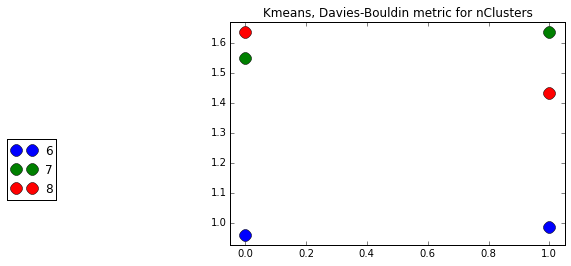

In [588]:
groups = riScores_db.groupby('nClusters')
# setX = 10 #actually a variable from the kmeans clustering...10 iterations
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(range(setSimulations), group.score, marker='o', linestyle='', ms=12, label=name)
ax.legend(bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, Davies-Bouldin metric for nClusters')
plt.show()

In [572]:
forest_run(dimensions, patterns_data, pattern_labels, metric='qe', 
           simulations=setSimulations, k_down=setKdown, k_up=setKup)

Updated best clustering
(0, [6, 1.00818287636444])
Updated best clustering
(1, [6, 0.9673956760513402])
Updated best clustering
(0, [7, 0.7754664481894836])
Updated best clustering
(1, [7, 0.7656126342922249])
Updated best clustering
(0, [8, 0.6887994541107645])
(1, [8, 0.6990241975972802])


In [589]:
riScores_qe=pd.read_csv('MonteCarloFinalResults_qe.csv',header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

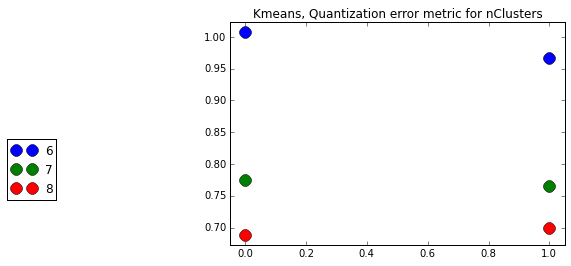

In [590]:
groups = riScores_qe.groupby('nClusters')
# setX = 10 #actually a variable from the kmeans clustering...10 iterations
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(range(setSimulations), group.score, marker='o', linestyle='', ms=12, label=name)
ax.legend(bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, Quantization error metric for nClusters')
plt.show()


In [576]:
#silhouette is quite slow cfd to the other two metrics
forest_run(dimensions, patterns_data, pattern_labels, metric='si', 
           simulations=setSimulations, k_down=setKdown, k_up=setKup)

Updated best clustering
(0, [6, 0.37648548425521733])
(1, [6, 0.379021297133865])
Updated best clustering
(0, [7, 0.365268159472868])
Updated best clustering
(1, [7, 0.35839397538410606])
(0, [8, 0.35931997361789103])
Updated best clustering
(1, [8, 0.34454253176783173])


In [591]:
riScores_si=pd.read_csv('MonteCarloFinalResults_si.csv',header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

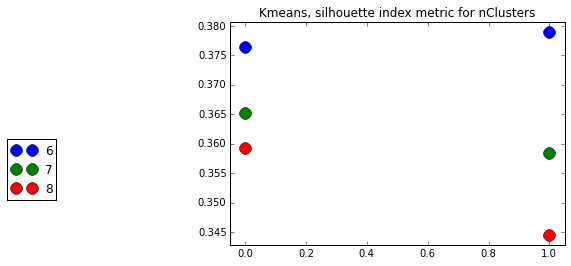

In [592]:
groups = riScores_si.groupby('nClusters')
# setX = 10 #actually a variable from the kmeans clustering...10 iterations
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(range(setSimulations), group.score, marker='o', linestyle='', ms=12, label=name)
ax.legend(bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, silhouette index metric for nClusters')
plt.show()


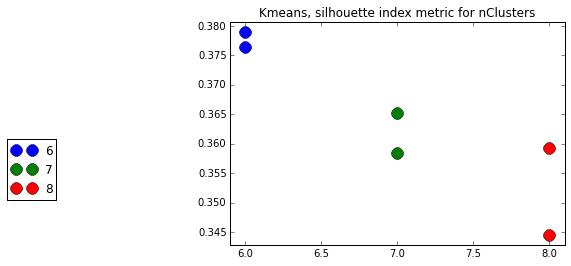

In [593]:
groups = riScores_si.groupby('nClusters')
# setX = 10 #actually a variable from the kmeans clustering...10 iterations
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.nClusters, group.score, marker='o', linestyle='', ms=12, label=name)
ax.legend(bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, silhouette index metric for nClusters')
plt.show()

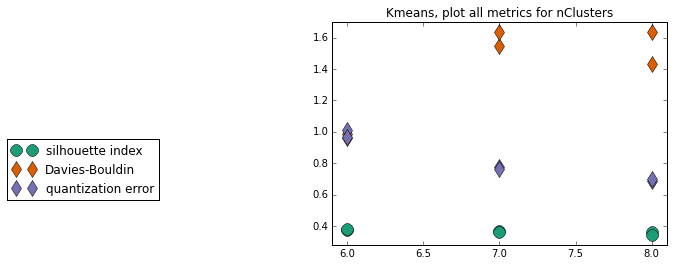

In [599]:
# riScores_si
# riScores_db
# riScores_qe

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.plot(riScores_si.nClusters,riScores_si.score,marker = 'o',linestyle='',ms=12,label=name,color = '#1b9e77')
ax.plot(riScores_db.nClusters,riScores_db.score,marker = 'd',linestyle='',ms=12,label=name,color = '#d95f02')
ax.plot(riScores_qe.nClusters,riScores_qe.score,marker = 'd',linestyle='',ms=12,label=name,color = '#7570b3')

fL = ['silhouette index','Davies-Bouldin','quantization error']
#how to I get the legend to only show one of the options? or do I need to change how I make the plot?
leg = ax.legend(fL,bbox_to_anchor=([-0.5, 0.5]))

plt.title('Kmeans, plot all metrics for nClusters')
plt.show()

#Move forward with 'best' number of clusters

In [ ]:
#KL, 9 October 2015 note...haven't done this next bit yet because I am setting the optimization code to run
#over the weekend.

In [ ]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
makeNclusters = 6

In [ ]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, makeNclusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

In [ ]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title('Cluster ' + str(y)+ ', ' + str(round(KPct,2))+'% Genes')
    fig.savefig('CombinedKOandCO_Kmeans')

PlotKmeansCombined(CcoClust,makeNclusters,2,3, 'r') 

##plot up the data..just a few here as a reminder of where we are heading

In [ ]:
#this setups up forPlotting as one, pre-defined Kmeans group
forPlotting = CcoClust[CcoClust.kmeans==2]

In [ ]:
forPlotting.shape
#literally put this here to slow down the notebook...I think it is a problem with the
#notebook not finishing up the image plotting before moving on...

Odd. Sometimes it seems that iPython notebook moves to the next cell before finishing the last one. When this happens, I get empty images? And empty matches...

In [ ]:
#this gets around the timing problem.
import time
time.sleep(60)

In [ ]:
#Start with the simple version
noMatch = []
#will use counter to limit the number of plots, remember skipping over KOnumbers 
#so index would require some guessing as to where the CO plots start
counter = 1 
for i,RI in enumerate(forPlotting.index):
    if counter < 5:
#     if (i >38) & (i < 40):
        if RI[0] == 'R':
            #have an RInumber, go get the Cnumber
            CO = convertRItoCO(CO_fromMATLAB,RI)
            
            #pull the Kmeans group for the title [presumably there is a one-liner for this]
            m = str(forPlotting.ix[i, 'kmeans'])
            Kg = m.rstrip('.0')
            del m 
            
            #there will be multiple (and varied) related KOs and COs
            try:
                kos=CO_withKO[CO]['Related KO']
                cos=CO_withKO[CO]['Related CO'] 

                #the kData are easy to process
                for k in kos: 
                    if k in forPlotting.index: 
                        kData=forPlotting.ix[kos,dayList].dropna()
                        kData=(kData.T/kData.sum(axis=1)).T

                #match the cos here with the RInumbers I generated
                tData = [];
                for c in cos:
                    m = findRInumber(forRelatedness,c)
                    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
                        tData.append(m)

                #flatten the list...since I don't need the different groups generated by the previous cell
                tData = list(chain.from_iterable(tData))

                cData=forPlotting.ix[tData,dayList].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)

                handles, labels = ax.get_legend_handles_labels()
                #convert the RI numbers to COnumbers for the figure
                for ia, a in enumerate(labels):
                    if a[0]=='R':
#                         Tracer()()
                        m = convertRItoCO(CO_fromMATLAB,a)
                        labels[ia] = m
                        #print i, m

                ax.legend(handles, labels)        
                fig.suptitle(CO + ' normalized data, Kmeans grp. ' + str(Kg))
                #fig.savefig(CO+'.png')
                counter = counter + 1
            except:
                #figure out later why some of these don't have a match
                noMatch.append(CO)

###focus on things with common linked reactions...

In [ ]:
#But...for the CheckRelatedness...do need to go back to the cNumber...
#for now, easiest to just make yet another matrix and put the cNumbers back in.
forRelatedness = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness.insert(0,'KEGG',"") #add a column called 'KEGG'
forRelatedness.head(5)

In [ ]:
for idx in range(0,len(forRelatedness)):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

In [ ]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        #note...re is one of the things imported at the very beginning
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object 
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
     
CheckRelatedness(forRelatedness, makeNclusters)

In [ ]:
def getKO_gene(KO):
    KO_httpstr='http://www.genome.jp/dbget-bin/www_bget?ko:'
    KOsite=urllib2.urlopen(KO_httpstr+KO)
    Ksoup=BeautifulSoup(KOsite)
    results = Ksoup.find_all("td",{"class":"td40"})
    m = results.pop(1) #treat results like a list and pop out the second line
    #clean up
    KOdetails = m.get_text(strip=True)
    return KOdetails

#can't seem to get rid of the u...marks information as unicode

In [ ]:
def getKO_pathway(KO):
    KO_httpstr='http://www.genome.jp/dbget-bin/www_bget?ko:'
    KOsite=urllib2.urlopen(KO_httpstr+KO)
    Ksoup=BeautifulSoup(KOsite)
    results = Ksoup.find_all("td",{"class":"td41"})
    m = results.pop(1) #treat results like a list and pop out the second line
    #clean up
    KOdetails = m.get_text(strip=True)
    return KOdetails

In [ ]:
#Now...change this to get the list of KO numbers showing up on both lists within a Kmeans group
commonKOgenes = {}
commonKOpathways = {}

# for n in range(makeNclusters):
for n in range(0,1):
    makeLabel = ("Km" + str(n),) #this combination of (XX,) will make a tuple to index dictionary
    kClust=forRelatedness[forRelatedness.kmeans==n]
    #i=kClust.index
    i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
    i=list(i)
    #note...re is one of the things imported at the very beginning
    Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object 
    Cs = filter(Csearc.search, i)
    Ksearc=re.compile('K.*')
    Kis = filter(Ksearc.search, i)
    Kis=set(Kis)
    Ks=[]
    for c in Cs:
        if c in CO_withKO.keys():
            Ks.append(CO_withKO[c]['Related KO'])
    Ks=set([item for sublist in Ks for item in sublist])

    KO_commonRxn = Kis.intersection(Ks)

    someListGene = []
    someListPathway = []

    for idx,k in enumerate(KO_commonRxn):
        m = getKO_gene(k)
        someListGene.append(m)
        
        m2 = getKO_pathway(k)
        someListPathway.append(m2)
        
    commonKOgenes[makeLabel] = list(someListGene)
    commonKOpathways[makeLabel] = list(someListPathway)



In [ ]:
#note the comma...
commonKOpathways['Km0',]

In [ ]:
#note the comma...
commonKOgenes['Km0',]

In [ ]:
commonKOgenes

In [ ]:
someDict['kMeans0'] = list(someList)

In [ ]:
someDict

In [ ]:
someDict['kMeans0']

In [ ]:
new_cols